**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [539]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
from IPython.display import display
from scipy.stats import norm
from sympy import simplify

import pandas as pd 
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from exam_niko import OptimalTaxation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Answer**

**Step 1: Define the symbols, objective function and the consumprion**

In [540]:
C = sm.symbols('C') # C is a Python variable representing the symbol C
G = sm.symbols('G')
L = sm.symbols('L')
w = sm.symbols('w')
wtilde = sm.symbols('wtilde')
alpha = sm.symbols('alpha')
nu = sm.symbols('nu')
kappa = sm.symbols('kappa')
tau = sm.symbols('tau')

In [562]:
objective = sm.log(C**alpha*G**(1-alpha))-nu*(L**2/2)
consumption = sm.Eq(C,kappa+wtilde*L) #wtilde = (1-tau)*w

In [585]:
objective

-L**2*nu/2 + log(C**alpha*G**(1 - alpha))

In [586]:
consumption

Eq(C, L*wtilde + kappa)

**Step 1** Solve using SymPy by substituting the consumption into the objective function, taking the derivative and solving for $L$.

In [591]:
objective_subs = objective.subs(C,consumption.rhs)
foc = sm.diff(objective_subs,L)
sol = sm.solve(foc,L)[1]
sol

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

**Step 2** Verify that the solution is the same as the one stated in the question.

In [592]:
verify = (-kappa + sm.sqrt(kappa**2+4*(alpha/nu)*wtilde**2))/(2*wtilde)
answer = sm.ask(sol == verify)
answer

False

In [584]:
verify

(-kappa - sqrt(4*alpha*wtilde**2/nu + kappa**2))/(2*wtilde)

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

**Answer question 2**

1. Setup baseline parameters in `self.__init__()` in the class `OptimalTaxation()`

2. Formulate the utility function in `self.calc_utility()`. Depending on the problem, 3 different utility functions are defined. 

3. Then the model is solved in `self.solve_model()`. Objective function and contraint is defined. As we use a numerical constraint optimizer that solves the argument by minimizing the objective function, we need to define the negative of the utility function as the objective function. The constraint ensures that the labor supplied cannot exceed 24 (as this is the maximum hours in a day). The solution is found by using the `scipy.optimize.minimize_scalar()` function. 

4. We solve the model for different wages in `self.solve_w_vec()`. We define a vector of wages and then loop over the vector and solve the model for each wage. The solution is saved in a vector containing the optimal labor supply for the given wage.  

5. Finally, we plot the optimal labor supply as a function of the wage in `self.plot_L()`.


In [548]:
model = OptimalTaxation()

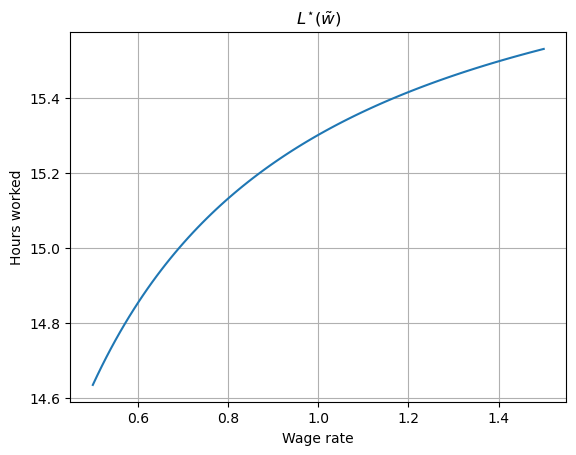

In [549]:
model.plot_L()

The plot look as you would expect. The higher the wage, the higher the optimal labour supply.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


**Answer question 3**

1. We reset so the wage is normalized to 1.

2. We solve the model for the case where government consumption is determined endogenously in `self.solve()`.

3. We solve the model for different $\tau$-values in `self.solve()`. We define a vector of $\tau$-values and then loop over the vector and solve the model for each $\tau$. The solution is saved in a vector containing the optimal labor supply, government consumption and utility for the given $\tau$-value.

4. Finally, we plot the optimal labor supply, government consumption and utility as a function of $\tau$ in `self.plot_results()`.


In [550]:
model.solve(extension=True, do_print=True)

Optimal labor supply with baseline parameters is 15.30


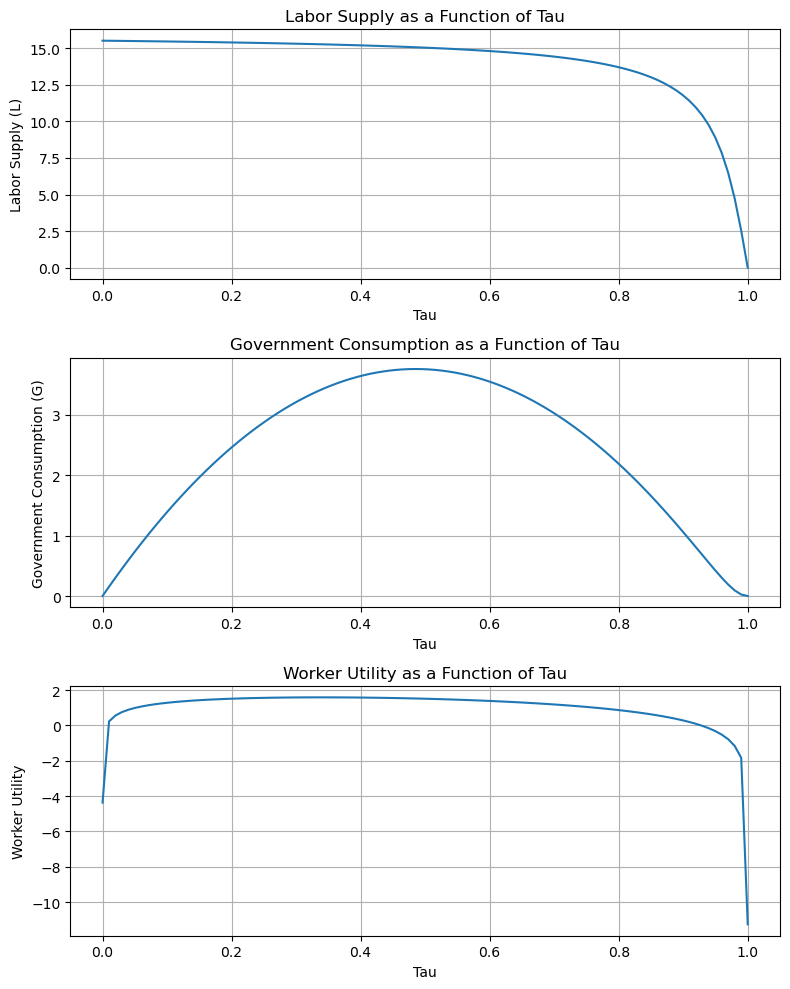

In [551]:
tau_grid = np.linspace(0.000001,0.999999,100) #grid of tau values. 
model.plot_results(tau_grid=tau_grid, extension=True)

**Labor supply as a function of $\tau$:** It is seen in the first plot that the labor supply is decreasing in $\tau$. This is because the higher the tax rate, the less attractive it is to work. However if the $\tau$ is equal to 0 or to 1 the labor supply is 24 hours. This is because if the tax rate is 0, the worker gets to keep all of the wage and if the tax rate is 1, the worker gets to keep all of the government consumption.

**Government consumption as a function of $\tau$** It is seen that the government consumption is first increasing in $\tau$, up utill some point whereafter it starts to decrease. This is because the higher the tax rate, the more money the government has to spend on government consumption, but at some point the tax rate is so high that the worker does not want to work anymore and therefore the government consumption decreases. 

**Worker utility as a function of $\tau$:** It is seen that the worker utility is first increasing in $\tau$, up utill some point whereafter it starts to decrease. This is because the worker gets utility both from consumption and from government consumption. However at some point, the disutility of working is going to outweigh the utility from government consumption and therefore the worker utility decreases as $\tau$ increases.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

**Answer question 4**   

1. Define a function that finds the optimal tax rate that maximizes the worker utility. The function is defined in `self.optimal_tax_cd()`. The function takes the baseline parameters as input and returns the optimal tax rate.

2. We plot the optimal tax rate in the plots from question 3. 

In [552]:
model.optimal_tax_cd(extension=True, do_print=True)

The tax rate that maximizes workers utility is 0.34


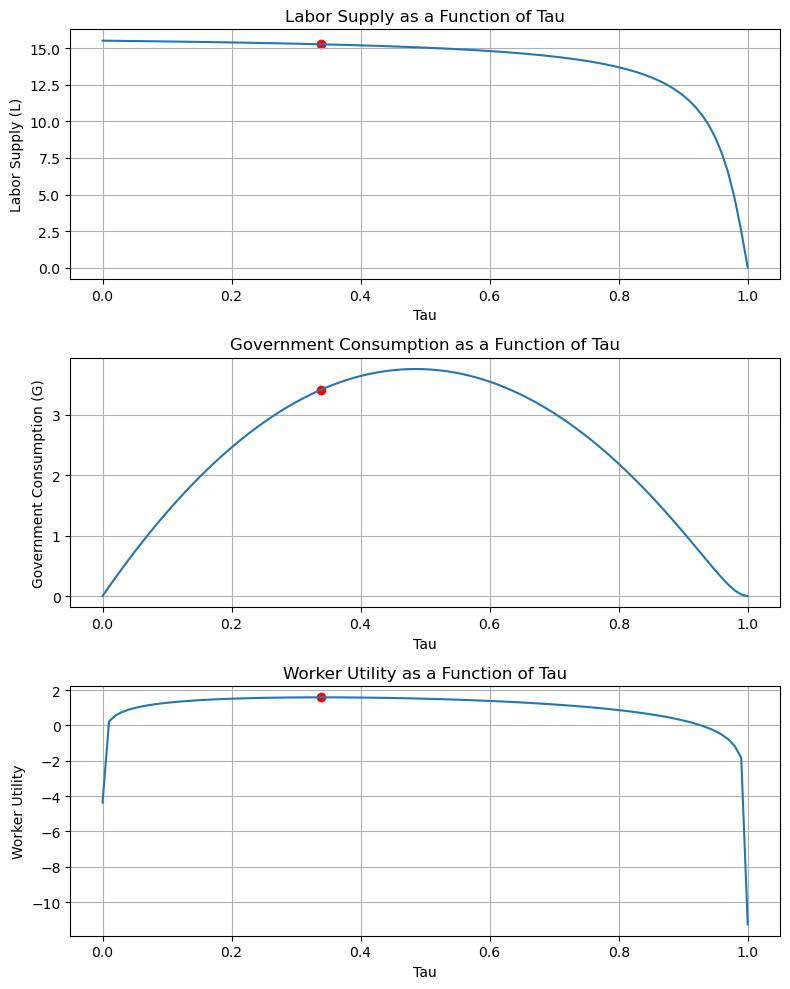

In [553]:
model.plot_results(tau_grid=tau_grid, extension=True, optimal_tax=True)

The optimal tax rate is plotted in each of the plots. It is seen that the optimal tax rate is around 0.34. 

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Answer question 5** 

1. A function `slef.calc_optimal_government_consumption()` is defined. The function calculates government consumption from the taxrate found in previous question. The function takes the baseline parameters as input and returns the government consumption. 

2. First the worker problem, that is the optimal labor supply, is solved for given values of G and $\tau$ and for wither the first or second set of parameters. 

3. Then the government consumption is calculated from the taxrate found in question 4 and from the optimal labor supply.

In [554]:
model.calc_optimal_government_consumption(CES=True, extension=True, do_print=True)

Government consumption with the second set of parameters is 3.41


In [555]:
model.calc_optimal_government_consumption(CES=True, extension=True, do_print=True, set_2=True)

Government consumption with the first set of parameters is 2.35


**Intuition:** With the first set of parameters, the more generel preferance formulation is approximately the same as the one used in previous questions. The optimal government consumption therefore is the same as we see in the plots from the previous question. When the second parameter set is used, the optimal government consumption falls. This is because the increase of $\sigma$ and $\rho$, makes the elasticity of consumption less than 1. That is the worker can not substitute consumption for government consumption as much as before. Therefore the optimal government consumption falls.

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

**Answer question 6** 

1. A function `slef.optimal_tax_ces()` is defined. The function calculates the optimal tax rate the maximizes worker utility keeping $G = \tau w L^{\star}((1-\tau)w,G)$ for either the first or the second set of parameters. 

2. First an objective function is defined in `self.optimal_tax_ces.obj()`. The objetive is defined by taking takes either G with the first parameter set or the second parameter set. As we want to call a minimizer the objective function is defined as the negative of the utility function.

3. A `scipy.optimize.minimize_scalar()` function is used to find the optimal tax rate.

In [557]:
model.optimal_tax_ces(CES=True, extension=True, do_print=True)

The tax rate that maximizes workers utility keeping G with the first set of parameters is 0.61


In [558]:
model.optimal_tax_ces(CES=True, extension=True, do_print=True, set_2=True)

The tax rate that maximizes workers utility keeping G with the second set of parameters is 0.47


**Intuition:** The intuition follows the intuition from question 5. With the first set of parameters, the optimal tax rate is the same as with the previous formulation of the preferences. With the second set of parameters

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [ ]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [ ]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [ ]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [ ]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
# write your code here